In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Input,InputLayer,Reshape,GRU,LSTM,Concatenate
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import models,Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D,GlobalAveragePooling2D
import pickle
from sklearn.metrics import confusion_matrix
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
import seaborn

In [3]:
#gpu = len(tf.config.list_physical_devices('GPU'))>0
#print("GPU is", "available" if gpu else "NOT AVAILABLE")
class CustomCallback(keras.callbacks.Callback):
    
    def __init__(self, threshold=0.8):
        super(CustomCallback, self).__init__()
        self.threshold = threshold
        
    def on_epoch_end(self, epoch, logs=None):
        if logs["accuracy"]>self.threshold:
            self.model.save_weights('D:/Project/Project_Server_Pred/model_weights/weights-threshold{}.h5'.format(self.threshold), overwrite=False)
            self.threshold =0.9
            print("80 percent saved")
        if logs["accuracy"]>self.threshold:
            self.model.save_weights('D:/Project/Project_Server_Pred/model_weights/weights-threshold{}.h5'.format(self.threshold), overwrite=False)
            self.threshold = 1
            print("90 percent saved")
            
def callbacks(name, tensorboard = False,customCallback=False, patience=35,location='D:/Project/Project_Server_Pred/model_weights/'):
    callbacks = [
        ModelCheckpoint(location+'/weights-{}.h5'.format(str(name)), monitor='val_loss', save_best_only=True, save_weights_only=True),
        EarlyStopping(patience=patience, monitor='val_loss', min_delta=0, mode='min'),
        
    ]
    if tensorboard:
        callbacks.append(TensorBoard(log_dir='./logs/{}'.format(name), histogram_freq=0, write_graph=True, write_images=True))
    if customCallback:
        callbacks.append(CustomCallback())
    return callbacks

In [5]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def normalize(x):
    x_reshaped = x.reshape(-1,x.shape[-1])
    mean,std=x_reshaped.mean(axis=0),x_reshaped.std(axis=0)
    x_reshaped = (x_reshaped - mean)/std
    #print(mean,std)
    return x_reshaped.reshape(x.shape)    #,mean,std

"""def plot_confusion_matrix(data, labels, output_filename=None):

    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix")
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels,rotation = 90)
    ax.set_yticklabels(labels,rotation = 90)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    #plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.close()
"""
def plotmetrics(fitMetrics):
  plt.subplot(4,2,1)
  plt.plot(fitMetrics.history['accuracy'])
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.title('accuracy')

  plt.subplot(4,2,2)
  plt.plot(fitMetrics.history['loss'])
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.title('loss')

  plt.subplot(4,2,3)
  plt.plot(fitMetrics.history['val_accuracy'])
  plt.xlabel('epochs')
  plt.ylabel('val_accuracy')
  plt.title('val_accuracy')

  plt.subplot(4,2,4)
  plt.plot(fitMetrics.history['val_loss'])
  plt.xlabel('epochs')
  plt.ylabel('val_loss')
  plt.title('val_loss')

  plt.subplot(4,2,5)
  plt.plot(fitMetrics.history['f1_m'])
  plt.xlabel('epochs')
  plt.ylabel('f1_m')
  plt.title('f1_m')

  plt.subplot(4,2,6)
  plt.plot(fitMetrics.history['precision_m'])
  plt.xlabel('epochs')
  plt.ylabel('precision_m')
  plt.title('precision_m')

  plt.subplot(4,2,7)
  plt.plot(fitMetrics.history['recall_m'])
  plt.xlabel('epochs')
  plt.ylabel('recall_m')
  plt.title('recall_m')
  plt.show()

def save_model_history(model,historypath,historymetric,modelpath):
  with open(historypath, 'wb') as file_pi:
          pickle.dump(historymetric.history, file_pi)
  model.save(modelpath+model_name[0])             


In [6]:
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,save_address=None):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize = 20,y = 1.02)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize = 20)
    plt.yticks(tick_marks, classes,fontsize = 20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 20)
    
    #plt.tight_layout()
    plt.ylabel('True label',fontsize = 20)
    plt.xlabel('Predicted label',fontsize = 20)
    
    if save_address is not None:
        plt.savefig(save_address,bbox_inches='tight')
    plt.show()
    
def show_confusion_matrix(model,data,label,title="Confusion Matrix",activity_list=None,save_add = None):
    y_pred = model.predict(data)
    tY=np.argmax(label,axis=1)
    y_p=np.argmax(y_pred, axis=1)
    cm = confusion_matrix(tY, y_p)
    #activity_list=['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
    if activity_list is None:
        activity_list=[ "WALKING","UPSTAIRS","DOWNSTAIRS","SITTING","STANDING","LAYING"]
    #activity_list=["walking","standing","running","jumping"]
    #activity_list=["walking","standing","running"]
    #activity_list=["SITTING","STANDING","LAYING"]
    plot_confusion_matrix(cm,activity_list,title=title,save_address=save_add)

# Models
#### 1.LSTM_CNN_SANDWICH
#### 2.LSTM_CNN
#### 3.LSTM_CNN_PARALLEL
#### 4.GRU_CNN
#### 5.CNN_GRU

In [8]:
def LSTM_CNN_SANDWICH(input_shape,output_shape):
    #K.set_image_data_format('channels_last')
    n_outputs = output_shape
    input_shape = input_shape
    
    input           = Input(shape=input_shape)
    lstm_1          = Bidirectional(LSTM(32,return_sequences=True))(input)
    activation_1    = Activation("relu")(lstm_1)
    reshape_layer_1 = Reshape((activation_1.shape[1],activation_1.shape[2],1))(activation_1)
    cnn_1           = Conv2D(64, (5,1), strides=(2,1), activation='relu')(reshape_layer_1)
    max_pool_1      = MaxPooling2D((2,1), strides=(2,1))(cnn_1)
    cnn_1_2         = Conv2D(32, (5,1), strides=(2,1), activation='relu')(max_pool_1)
    max_pool_1_2    = MaxPooling2D((2,1), strides=(2,1))(cnn_1_2)
    batch_norm_1    = BatchNormalization()(max_pool_1_2)
    dropout_2       = Dropout(0.6)(batch_norm_1)

    reshape_layer_2 = Reshape((-1,cnn_1.shape[3]))(dropout_2)
    lstm_2          = Bidirectional(LSTM(32,return_sequences=True))(reshape_layer_2)
    activation_2    = Activation("relu")(lstm_2)
    reshape_layer_3 = Reshape((activation_2.shape[1],activation_2.shape[2],1))(activation_2)
    cnn_2           = Conv2D(64, (5,1), strides=(2,1), activation='relu')(reshape_layer_3)
    max_pool_2      = MaxPooling2D((2,1), strides=(2,1))(cnn_2)
    cnn_2_2         = Conv2D(32, (5,1), strides=(2,1), activation='relu')(max_pool_2)
    max_pool_2_2    = MaxPooling2D((2,1), strides=(2,1))(cnn_2_2)
    batch_norm_2    = BatchNormalization()(max_pool_2_2)
    global_avg      = GlobalAveragePooling2D()(batch_norm_2)
    dropout_3       = Dropout(0.6)(global_avg)

    dense           = Dense(n_outputs)(dropout_3)
    activation_3    = Activation("softmax")(dense)

    model = Model(inputs = input, outputs= activation_3)
    #model.summary()

    rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])

    return model

In [10]:
def LSTM_CNN(input_shape=None,n_outputs=None):
    
    #K.set_image_data_format('channels_last')
    n_outputs = n_outputs
    input_shape = input_shape
    input           = Input(shape=input_shape)

    lstm_1          = Bidirectional(LSTM(32,return_sequences=True))(input)
    activation_1    = Activation("relu")(lstm_1)
    lstm_2          = Bidirectional(LSTM(32,return_sequences=True))(activation_1)
    activation_2    = Activation("relu")(lstm_2)

    reshape_layer_1 = Reshape((lstm_2.shape[1],lstm_2.shape[2],1))(activation_2)
    
    cnn_1           = Conv2D(64, (5,5), strides=(2,2), activation='relu')(reshape_layer_1)
    max_pool_1      = MaxPooling2D((2,2), strides=(2,2))(cnn_1)
    cnn_2           = Conv2D(128, (3,3), strides=(1,1), activation='relu')(max_pool_1)
    global_avg      = GlobalAveragePooling2D()(cnn_2)
    dense           = Dense(n_outputs,activation='softmax',kernel_regularizer=keras.regularizers.l2(0.005))(global_avg)

    model = Model(inputs = input, outputs= dense)
    #model.summary()

    rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001)

    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])
    
    
    return model

In [12]:
def LSTM_CNN_PARALLEL(input_shape=None,n_outputs=None):
    
    #K.set_image_data_format('channels_last')
    input_shape = input_shape
    input           = Input(shape=input_shape)

    lstm_1          = Bidirectional(LSTM(32,return_sequences=True))(input)
    activation_1    = Activation("relu")(lstm_1)
    lstm_2          = Bidirectional(LSTM(32,return_sequences=True))(activation_1)
    activation_2    = Activation("relu")(lstm_2)
    flatten         = Flatten()(activation_2)

    reshape_2         = Reshape((input.shape[1],input.shape[2],1))(input)
    cnn_1_2           = Conv2D(64, (5,1), activation='relu')(reshape_2)
    #max_pool_1_2     = MaxPooling2D((2,2), strides=(2,2))(cnn_1_2)
    cnn_2_2           = Conv2D(128, (3,3), strides=(1,1), activation='relu')(cnn_1_2)
    global_avg_2      = GlobalAveragePooling2D()(cnn_2_2)
    dropout_layer_2      = Dropout(0.5)(global_avg_2)
    
    flatten_2         = Flatten()(dropout_layer_2)

    concatenate       = Concatenate()([flatten,flatten_2])
    dense             = Dense(n_outputs,activation='softmax',kernel_regularizer=keras.regularizers.l2(0.005))(concatenate)



    model = Model(inputs = input, outputs= dense)
    #model.summary()

    rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])
    
    
    return model

In [14]:
def GRU_CNN(input_shape,output_shape):
    #K.set_image_data_format('channels_last')
    
    n_outputs = output_shape
    input_shape = input_shape
    
    input = Input(shape = input_shape)
    gru_1 = GRU(32, return_sequences = True, activation = 'tanh')(input)
    gru_2 = GRU(32, return_sequences = True, activation = 'tanh')(gru_1)
    rehsape_layer_1 = Reshape((gru_2.shape[1],gru_2.shape[2],1))(gru_2)
    cnn_1 = Conv2D(64, (5,5), strides=(2,2), activation='relu')(rehsape_layer_1)
    max_pool_1 = MaxPooling2D((2,2), strides=(2,2)) (cnn_1)
    cnn_2 = Conv2D(128, (3,3), strides=(1,1), activation='relu')(max_pool_1)

    global_avg = GlobalAveragePooling2D()(cnn_2)
    batch_norm = BatchNormalization()(global_avg)

    dense = Dense(n_outputs,activation ='softmax') (batch_norm)

    model = Model(inputs = input,outputs = dense)
    #model.summary()
    rmsprop=tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])

    return model

In [15]:
def CNN_GRU(input_shape,output_shape):
    #K.set_image_data_format('channels_last')
    
    n_outputs = output_shape
    input_shape = input_shape
    
    input   = Input(shape=input_shape)
    reshape_layer = Reshape((input.shape[1],input.shape[2],1)) (input)
    cnn_1         = Conv2D(128, (5,1), strides=(1,1), activation='relu') (reshape_layer)
    max_pool_1    = MaxPooling2D((2,1)) (cnn_1)
    cnn_2         = Conv2D(64, (3,1), strides=(1,1), activation='relu') (max_pool_1)
    max_pool_2    = MaxPooling2D((2,1)) (cnn_2)
    cnn_3         = Conv2D(32, (3,2), strides=(1,1), activation='relu') (max_pool_2)
    max_pool_3    = MaxPooling2D((2,1)) (cnn_3)
    batch_norm    = BatchNormalization()(max_pool_3)

    reshape_layer_2 = Reshape((-1,batch_norm.shape[3]))(batch_norm)
    gru_1 = GRU(32, return_sequences = True, activation = 'tanh')(reshape_layer_2)
    gru_2 = GRU(32, activation = 'tanh')(gru_1)

    #global_avg = GlobalAveragePooling2D()(gru_2)
    batch_norm = BatchNormalization()(gru_2)

    dense = Dense(n_outputs,activation ='softmax') (batch_norm)

    model = Model(inputs = input,outputs = dense)

    #model.summary()

    rmsprop=tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m,recall_m])
    
    return model

In [16]:
model_list = [LSTM_CNN_SANDWICH,LSTM_CNN,LSTM_CNN_PARALLEL,GRU_CNN,CNN_GRU]
model_name = ['LSTM_CNN_SANDWICH','LSTM_CNN','LSTM_CNN_PARALLEL','GRU_CNN','CNN_GRU']

# Data Section

In [17]:
def getTrainingData(filepath):
  testX = pickle.load(open(filepath[0],"rb"))
  testY = pickle.load(open(filepath[1],"rb"))

  trainX = pickle.load(open(filepath[2],"rb"))   
  trainY = pickle.load(open(filepath[3],"rb"))

  valX = pickle.load(open(filepath[4],"rb"))
  valY = pickle.load(open(filepath[5],"rb"))
    
  if "D:/Project/Datasets/Real_world_Dataset" in filepath[0] or  "D:/Project/Datasets/WISDM_Dataset/WISDM_testX" in filepath[0]:
        testY  = to_categorical(testY)
        trainY = to_categorical(trainY)
        valY   = to_categorical(valY)
  else:  
      testY  = testY-1
      trainY = trainY-1
      valY   = valY-1
      testY  = to_categorical(testY)
      trainY = to_categorical(trainY)
      valY   = to_categorical(valY)

  #FFT of X data
  #print("1----",UCItrainX.shape,UCItestX.shape,UCIvalX.shape)
  trainX = np.transpose(trainX,(0,2,1))
  testX  = np.transpose(testX,(0,2,1))
  valFFTX   = np.transpose(valX,(0,2,1))

  #print("2----",UCItrainX.shape,UCItestX.shape,valFFTX.shape)
  trainFFT = np.abs(fft(trainX))
  testFFT  = np.abs(fft(testX))
  valFFT   = np.abs(fft(valFFTX))

  trainX_FFT = np.transpose(trainFFT,(0,2,1))
  testX_FFT  = np.transpose(testFFT,(0,2,1))
  valX_FFT   = np.transpose(valFFT,(0,2,1))
  #print("3----",trainX_FFT.shape,testX_FFT.shape,valX_FFT.shape)

  #Half portion of the fft data taken
  half_trainFFT = np.delete(trainX_FFT,np.arange(64,128),axis=1)
  half_testFFT  = np.delete(testX_FFT,np.arange(64,128),axis=1)
  half_valFFT   = np.delete(valX_FFT,np.arange(64,128),axis=1)

  #normalizedData
  normhalf_trainFFT = normalize(half_trainFFT)
  normhalf_testFFT  = normalize(half_testFFT)
  normhalf_valFFT   = normalize(half_valFFT)  

  return half_trainFFT,trainY,half_testFFT,testY,half_valFFT,valY

In [18]:
UCI = ["D:/Project/Datasets/UCI_HAPT_DATASET/UCI_ALL_testX","D:/Project/Datasets/UCI_HAPT_DATASET/UCI_ALL_testY",
       "D:/Project/Datasets/UCI_HAPT_DATASET/UCI_ALL_trainX","D:/Project/Datasets/UCI_HAPT_DATASET/UCI_ALL_trainY",
       "D:/Project/Datasets/UCI_HAPT_DATASET/UCI_ALL_valX","D:/Project/Datasets/UCI_HAPT_DATASET/UCI_ALL_valY"]

RealWorld = ["D:/Project/Datasets/Real_world_Dataset/RW_SMALL_testX","D:/Project/Datasets/Real_world_Dataset/RW_SMALL_testY",
       "D:/Project/Datasets/Real_world_Dataset/RW_SMALL_trainX","D:/Project/Datasets/Real_world_Dataset/RW_SMALL_trainY",
       "D:/Project/Datasets/Real_world_Dataset/RW_SMALL_valX","D:/Project/Datasets/Real_world_Dataset/RW_SMALL_valY"] 

WISDM = ["D:/Project/Datasets/WISDM_Dataset/WISDM_testX","D:/Project/Datasets/WISDM_Dataset/WISDM_testY",
       "D:/Project/Datasets/WISDM_Dataset/WISDM_AUG_NEW_trainX","D:/Project/Datasets/WISDM_Dataset/WISDM_AUG_NEW_trainY",
       "D:/Project/Datasets/WISDM_Dataset/WISDM_valX","D:/Project/Datasets/WISDM_Dataset/WISDM_valY"] 


In [13]:
trainY = np.array(pickle.load(open("D:/Project/Datasets/WISDM_Dataset/WISDM_valY","rb"))).transpose()
print(trainY[0])
a = np.array([0, 3, 0, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 3, 4])
unique, counts = np.unique(trainY[0], return_counts=True)
dict(zip(unique, counts))


[1. 1. 1. ... 3. 3. 3.]


{0.0: 2823, 1.0: 3743, 2.0: 1206, 3.0: 956, 4.0: 509, 5.0: 578}

In [19]:
UCIhalf_trainFFT,UCItrainY,UCIhalf_testFFT,UCItestY,UCIhalf_valFFT,UCIvalY = getTrainingData(UCI)
RealWorldhalf_trainFFT,RealWorldtrainY,RealWorldhalf_testFFT,RealWorldtestY,RealWorldhalf_valFFT,RealWorldvalY = getTrainingData(RealWorld)
WISDMhalf_trainFFT,WISDMtrainY,WISDMhalf_testFFT,WISDMtestY,WISDMhalf_valFFT,WISDMvalY = getTrainingData(WISDM)

In [20]:
print("UCI-----",UCIhalf_trainFFT.shape,UCItrainY.shape,UCIhalf_testFFT.shape,UCItestY.shape,UCIhalf_valFFT.shape,UCIvalY.shape)
print("RealWorld-----",RealWorldhalf_trainFFT.shape,RealWorldtrainY.shape,RealWorldhalf_testFFT.shape,RealWorldtestY.shape,RealWorldhalf_valFFT.shape,RealWorldvalY.shape)
print("WISDM-----",WISDMhalf_trainFFT.shape,WISDMtrainY.shape,WISDMhalf_testFFT.shape,WISDMtestY.shape,WISDMhalf_valFFT.shape,WISDMvalY.shape)

UCI----- (8618, 64, 9) (8618, 12) (2172, 64, 9) (2172, 12) (1356, 64, 9) (1356, 12)
RealWorld----- (11285, 64, 9) (11285, 6) (4585, 64, 9) (4585, 6) (4571, 64, 9) (4571, 6)
WISDM----- (34744, 64, 3) (34744, 6) (8331, 64, 3) (8331, 6) (9815, 64, 3) (9815, 6)


In [21]:
UCIInputShape = UCIhalf_trainFFT.shape[1:]
RealWorldInputShape = RealWorldhalf_trainFFT.shape[1:]
WISDMInputShape = WISDMhalf_trainFFT.shape[1:]
UCIoutputs = UCItrainY.shape[1]
RealWorldoutputs = RealWorldtrainY.shape[1]
WISDMoutputs = WISDMtrainY.shape[1]

In [22]:
print("UCI----->",UCIInputShape,UCIoutputs)
print("RW----->",RealWorldInputShape,RealWorldoutputs)
print("UCI----->",WISDMInputShape,WISDMoutputs)

UCI-----> (64, 9) 12
RW-----> (64, 9) 6
UCI-----> (64, 3) 6


In [23]:
UCILabels = ["WALKING","UPSTAIRS","DOWNSTAIRS","SITTING","STANDING","LAYING","STAND_TO_SIT","SIT_TO_STAND","SIT_TO_LIE","LIE_TO_SIT","STAND_TO_LIE","LIE_TO_STAND"]
RWLabels = ["Walking","Standing","Sitting","Running","Lying","Jumping","Up","Down"]
WISDMLabels = ["Jogging","Walking","UpStairs","DownStairs","Sitting","Standing"]

# Model Definition

In [24]:
UCImodels = {key: value(UCIInputShape,UCIoutputs) for (key, value) in zip(model_name,model_list)}
RealWorldmodels = {key: value(RealWorldInputShape,RealWorldoutputs) for (key, value) in zip(model_name,model_list)}
WISDMmodels = {key: value(WISDMInputShape,WISDMoutputs) for (key, value) in zip(model_name,model_list)}

In [20]:
#'LSTM_CNN_SANDWICH','LSTM_CNN','LSTM_CNN_PARALLEL','GRU_CNN','CNN_GRU'
UCImodels['LSTM_CNN_SANDWICH'].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 9)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64, 64)            10752     
_________________________________________________________________
activation (Activation)      (None, 64, 64)            0         
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 64, 64)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 64, 32)         10272 

### UCI model training
#### LSTM_CNN_SANDWICH

In [ ]:
UCILSTM_CNN_SANDWICH = UCImodels['LSTM_CNN_SANDWICH'].fit(UCIhalf_trainFFT, UCItrainY, epochs = 150, batch_size = 200, validation_data = (UCIhalf_valFFT, UCIvalY),
                                                         callbacks=callbacks("UCILSTM_CNN_SANDWICH", patience=30))

Epoch 1/150
44/44 [==============================] - 56s 298ms/step - loss: 2.3613 - accuracy: 0.2111 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.4763 - val_accuracy: 0.1423 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - accuracy: 
Epoch 2/150
44/44 [==============================] - 9s 204ms/step - loss: 2.0501 - accuracy: 0.2849 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.4717 - val_accuracy: 0.1423 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/150
44/44 [==============================] - 9s 204ms/step - loss: 1.8854 - accuracy: 0.2968 - f1_m: 0.0038 - precision_m: 0.1970 - recall_m: 0.0019 - val_loss: 2.4581 - val_accuracy: 0.1423 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00ion_m: 0.2042 - recall_m
Epoch 4/150
44/44 [==============================] - 9s 207ms/step - loss: 1.8054 - accuracy: 0.2993 

In [ ]:
plotmetrics(UCILSTM_CNN_SANDWICH)

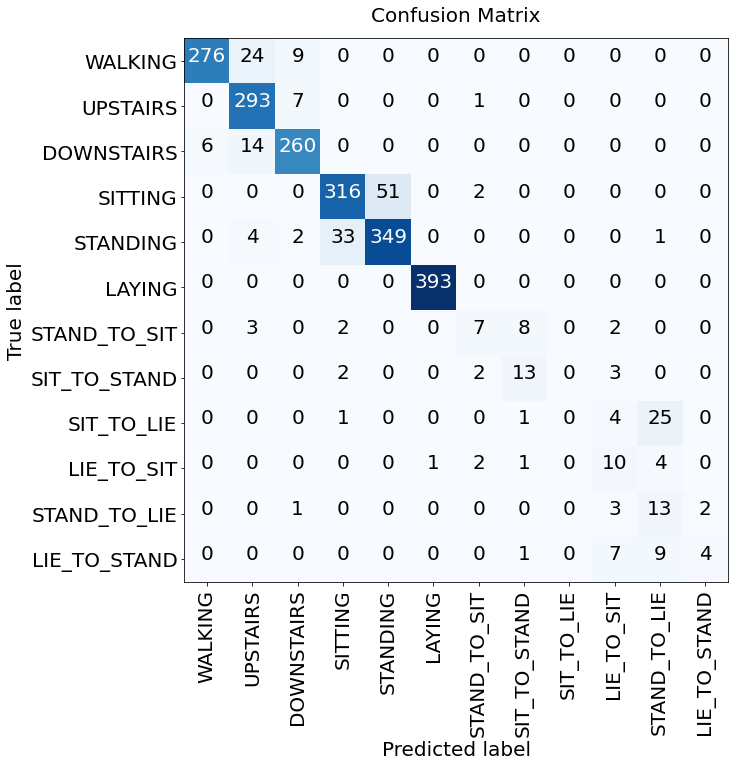

In [35]:
show_confusion_matrix(UCImodels['LSTM_CNN_SANDWICH'],UCIhalf_testFFT,UCItestY,title="Confusion Matrix",activity_list=UCILabels,save_add = None)

In [36]:
save_model_history(UCImodels['LSTM_CNN_SANDWICH'],'D:/Project/Datasets/UCI_HAPT_DATASET/UCIUCILSTM_CNN_SANDWICHhistory',UCILSTM_CNN_SANDWICH,'D:/Project/Datasets/UCI_HAPT_DATASET/UCI_UCILSTM_CNN_SANDWICH')

INFO:tensorflow:Assets written to: D:/Project/Datasets/UCI_HAPT_DATASET/UCI_UCILSTM_CNN_SANDWICHLSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/UCI_HAPT_DATASET/UCI_UCILSTM_CNN_SANDWICHLSTM_CNN_SANDWICH\assets


#### LSTM_CNN

In [39]:
UCILSTM_CNN = UCImodels['LSTM_CNN'].fit(UCIhalf_trainFFT, UCItrainY, epochs = 150, batch_size = 200, validation_data = (UCIhalf_valFFT, UCIvalY),callbacks=callbacks("UCILSTM_CNN", patience=30))

Epoch 1/150
44/44 [==============================] - 3s 75ms/step - loss: 0.0695 - accuracy: 0.9806 - f1_m: 0.9798 - precision_m: 0.9812 - recall_m: 0.9784 - val_loss: 1.2526 - val_accuracy: 0.8038 - val_f1_m: 0.8059 - val_precision_m: 0.8099 - val_recall_m: 0.8019
Epoch 2/150
44/44 [==============================] - 3s 75ms/step - loss: 0.0829 - accuracy: 0.9747 - f1_m: 0.9753 - precision_m: 0.9761 - recall_m: 0.9744 - val_loss: 1.1990 - val_accuracy: 0.7994 - val_f1_m: 0.8040 - val_precision_m: 0.8100 - val_recall_m: 0.7981
Epoch 3/150
44/44 [==============================] - 3s 75ms/step - loss: 0.0652 - accuracy: 0.9785 - f1_m: 0.9795 - precision_m: 0.9805 - recall_m: 0.9785 - val_loss: 1.0392 - val_accuracy: 0.8127 - val_f1_m: 0.8156 - val_precision_m: 0.8183 - val_recall_m: 0.8128
Epoch 4/150
44/44 [==============================] - 3s 75ms/step - loss: 0.0797 - accuracy: 0.9745 - f1_m: 0.9757 - precision_m: 0.9775 - recall_m: 0.9740 - val_loss: 1.1185 - val_accuracy: 0.8068 - va

Epoch 32/150
44/44 [==============================] - 4s 80ms/step - loss: 0.0743 - accuracy: 0.9805 - f1_m: 0.9808 - precision_m: 0.9818 - recall_m: 0.9798 - val_loss: 1.0078 - val_accuracy: 0.8156 - val_f1_m: 0.8182 - val_precision_m: 0.8209 - val_recall_m: 0.8156
Epoch 33/150
44/44 [==============================] - 4s 80ms/step - loss: 0.0464 - accuracy: 0.9875 - f1_m: 0.9873 - precision_m: 0.9884 - recall_m: 0.9863 - val_loss: 1.2895 - val_accuracy: 0.7847 - val_f1_m: 0.7890 - val_precision_m: 0.7918 - val_recall_m: 0.7863
Epoch 34/150
44/44 [==============================] - 4s 80ms/step - loss: 0.0680 - accuracy: 0.9836 - f1_m: 0.9837 - precision_m: 0.9844 - recall_m: 0.9831 - val_loss: 1.3572 - val_accuracy: 0.7957 - val_f1_m: 0.7984 - val_precision_m: 0.8007 - val_recall_m: 0.7961
Epoch 35/150
44/44 [==============================] - 4s 80ms/step - loss: 0.0480 - accuracy: 0.9868 - f1_m: 0.9869 - precision_m: 0.9873 - recall_m: 0.9865 - val_loss: 1.4030 - val_accuracy: 0.7824 

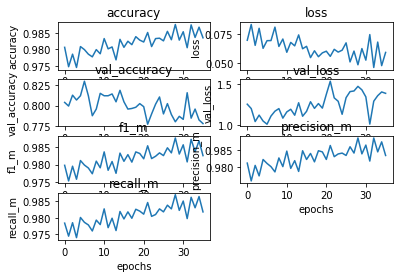

In [40]:
plotmetrics(UCILSTM_CNN)

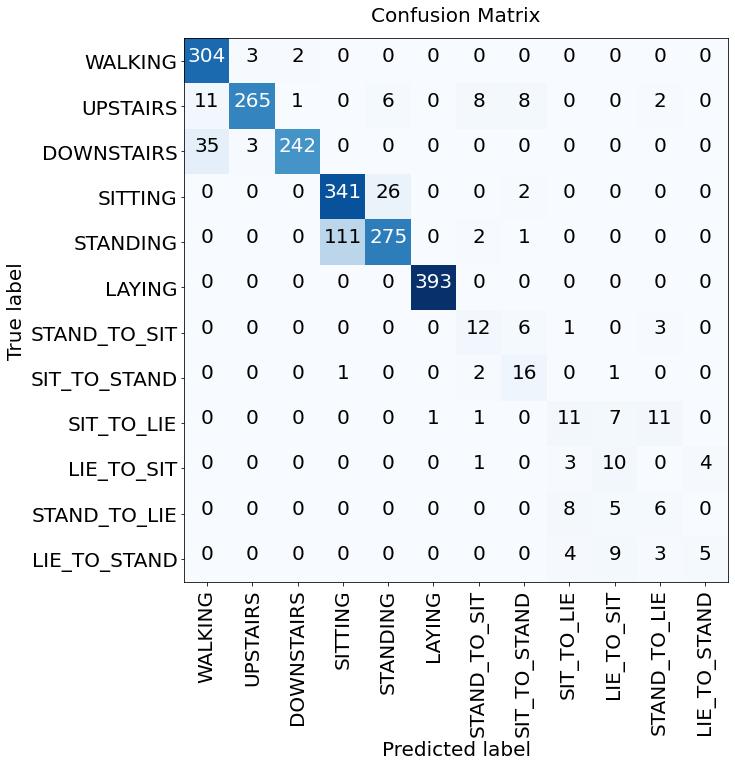

In [41]:
show_confusion_matrix(UCImodels['LSTM_CNN'],UCIhalf_testFFT,UCItestY,title="Confusion Matrix",activity_list=UCILabels,save_add = None)

In [54]:
save_model_history(UCImodels['LSTM_CNN'],'D:/Project/Datasets/UCI_HAPT_DATASET/UCIUCILSTM_CNNhistory',UCILSTM_CNN,'D:/Project/Datasets/UCI_HAPT_DATASET/UCI_UCILSTM_CNN')

INFO:tensorflow:Assets written to: D:/Project/Datasets/UCI_HAPT_DATASET/UCI_UCILSTM_CNNLSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/UCI_HAPT_DATASET/UCI_UCILSTM_CNNLSTM_CNN_SANDWICH\assets


#### LSTM_CNN_PARALLEL

In [42]:
UCILSTM_CNN_PARALLEL = UCImodels['LSTM_CNN_PARALLEL'].fit(UCIhalf_trainFFT, UCItrainY, epochs = 150, batch_size = 200, validation_data = (UCIhalf_valFFT, UCIvalY),callbacks=callbacks("UCILSTM_CNN_PARALLEL", patience=30))

Epoch 1/150
44/44 [==============================] - 12s 110ms/step - loss: 2.2100 - accuracy: 0.2793 - f1_m: 4.5228e-04 - precision_m: 0.0455 - recall_m: 2.2727e-04 - val_loss: 2.0235 - val_accuracy: 0.3761 - val_f1_m: 0.0014 - val_precision_m: 0.1429 - val_recall_m: 7.1429e-04
Epoch 2/150
44/44 [==============================] - 2s 55ms/step - loss: 1.8543 - accuracy: 0.4278 - f1_m: 0.0178 - precision_m: 0.6267 - recall_m: 0.0091 - val_loss: 1.7027 - val_accuracy: 0.3886 - val_f1_m: 0.0725 - val_precision_m: 0.4161 - val_recall_m: 0.0400
Epoch 3/150
44/44 [==============================] - 3s 58ms/step - loss: 1.5068 - accuracy: 0.5379 - f1_m: 0.0639 - precision_m: 0.7997 - recall_m: 0.0336 - val_loss: 1.4114 - val_accuracy: 0.5081 - val_f1_m: 0.0751 - val_precision_m: 0.3824 - val_recall_m: 0.0421
Epoch 4/150
44/44 [==============================] - 3s 58ms/step - loss: 1.2966 - accuracy: 0.5933 - f1_m: 0.1357 - precision_m: 0.7804 - recall_m: 0.0750 - val_loss: 1.3407 - val_accurac

Epoch 62/150
44/44 [==============================] - 2s 47ms/step - loss: 0.2295 - accuracy: 0.9368 - f1_m: 0.9375 - precision_m: 0.9602 - recall_m: 0.9159 - val_loss: 0.4780 - val_accuracy: 0.8363 - val_f1_m: 0.8385 - val_precision_m: 0.8636 - val_recall_m: 0.8149
Epoch 63/150
44/44 [==============================] - 2s 46ms/step - loss: 0.2271 - accuracy: 0.9371 - f1_m: 0.9359 - precision_m: 0.9563 - recall_m: 0.9164 - val_loss: 0.4940 - val_accuracy: 0.8378 - val_f1_m: 0.8426 - val_precision_m: 0.8655 - val_recall_m: 0.8211
Epoch 64/150
44/44 [==============================] - 2s 46ms/step - loss: 0.2239 - accuracy: 0.9380 - f1_m: 0.9366 - precision_m: 0.9572 - recall_m: 0.9171 - val_loss: 0.5163 - val_accuracy: 0.8319 - val_f1_m: 0.8340 - val_precision_m: 0.8541 - val_recall_m: 0.8150
Epoch 65/150
44/44 [==============================] - 2s 46ms/step - loss: 0.2241 - accuracy: 0.9368 - f1_m: 0.9361 - precision_m: 0.9564 - recall_m: 0.9168 - val_loss: 0.6187 - val_accuracy: 0.7987 

44/44 [==============================] - 2s 43ms/step - loss: 0.1664 - accuracy: 0.9513 - f1_m: 0.9506 - precision_m: 0.9641 - recall_m: 0.9376 - val_loss: 0.5345 - val_accuracy: 0.8437 - val_f1_m: 0.8517 - val_precision_m: 0.8736 - val_recall_m: 0.8312
Epoch 123/150
44/44 [==============================] - 2s 43ms/step - loss: 0.1650 - accuracy: 0.9532 - f1_m: 0.9511 - precision_m: 0.9649 - recall_m: 0.9378 - val_loss: 0.5084 - val_accuracy: 0.8333 - val_f1_m: 0.8390 - val_precision_m: 0.8588 - val_recall_m: 0.8203
Epoch 124/150
44/44 [==============================] - 2s 44ms/step - loss: 0.1625 - accuracy: 0.9529 - f1_m: 0.9536 - precision_m: 0.9661 - recall_m: 0.9416 - val_loss: 0.4882 - val_accuracy: 0.8341 - val_f1_m: 0.8420 - val_precision_m: 0.8591 - val_recall_m: 0.8257
Epoch 125/150
44/44 [==============================] - 2s 43ms/step - loss: 0.1642 - accuracy: 0.9537 - f1_m: 0.9536 - precision_m: 0.9659 - recall_m: 0.9417 - val_loss: 0.4967 - val_accuracy: 0.8518 - val_f1_m

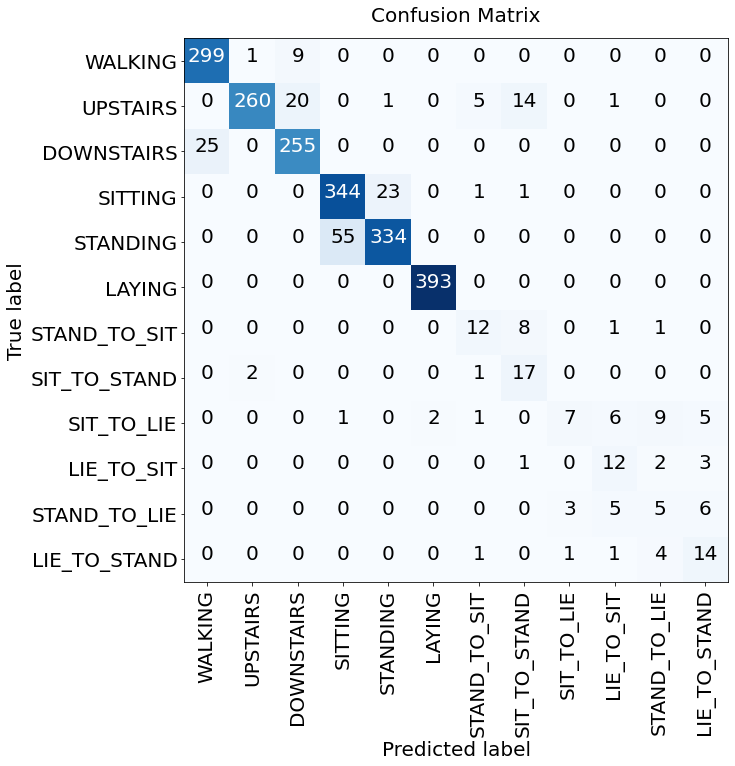

In [43]:
show_confusion_matrix(UCImodels['LSTM_CNN_PARALLEL'],UCIhalf_testFFT,UCItestY,title="Confusion Matrix",activity_list=UCILabels,save_add = None)

In [55]:
save_model_history(UCImodels['LSTM_CNN_PARALLEL'],'D:/Project/Datasets/UCI_HAPT_DATASET/UCIUCILSTM_CNN_PARALLELhistory',UCILSTM_CNN_PARALLEL,'D:/Project/Datasets/UCI_HAPT_DATASET/UCI_UCILSTM_CNN_PARALLEL')

INFO:tensorflow:Assets written to: D:/Project/Datasets/UCI_HAPT_DATASET/UCI_UCILSTM_CNN_PARALLELLSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/UCI_HAPT_DATASET/UCI_UCILSTM_CNN_PARALLELLSTM_CNN_SANDWICH\assets


#### GRU_CNN

In [48]:
UCIGRU_CNN = UCImodels['GRU_CNN'].fit(UCIhalf_trainFFT, UCItrainY, epochs = 150, batch_size = 200, validation_data = (UCIhalf_valFFT, UCIvalY),callbacks=callbacks("UCIGRU_CNN", patience=30))

Epoch 1/150
44/44 [==============================] - 2s 35ms/step - loss: 0.0442 - accuracy: 0.9835 - f1_m: 0.9838 - precision_m: 0.9839 - recall_m: 0.9838 - val_loss: 0.6200 - val_accuracy: 0.8628 - val_f1_m: 0.8655 - val_precision_m: 0.8682 - val_recall_m: 0.8628uracy: 0.9812 - f1_m: 0.9812 - precision_m: 0
Epoch 2/150
44/44 [==============================] - 1s 33ms/step - loss: 0.0425 - accuracy: 0.9820 - f1_m: 0.9824 - precision_m: 0.9826 - recall_m: 0.9823 - val_loss: 0.6719 - val_accuracy: 0.8791 - val_f1_m: 0.8802 - val_precision_m: 0.8822 - val_recall_m: 0.8782
Epoch 3/150
44/44 [==============================] - 1s 33ms/step - loss: 0.0448 - accuracy: 0.9840 - f1_m: 0.9833 - precision_m: 0.9836 - recall_m: 0.9831 - val_loss: 0.8207 - val_accuracy: 0.8473 - val_f1_m: 0.8515 - val_precision_m: 0.8545 - val_recall_m: 0.8486
Epoch 4/150
44/44 [==============================] - 1s 33ms/step - loss: 0.0439 - accuracy: 0.9839 - f1_m: 0.9841 - precision_m: 0.9842 - recall_m: 0.9840 -

Epoch 31/150
44/44 [==============================] - 1s 34ms/step - loss: 0.0306 - accuracy: 0.9887 - f1_m: 0.9890 - precision_m: 0.9890 - recall_m: 0.9890 - val_loss: 0.6901 - val_accuracy: 0.8835 - val_f1_m: 0.8833 - val_precision_m: 0.8846 - val_recall_m: 0.8820
Epoch 32/150
44/44 [==============================] - 2s 34ms/step - loss: 0.0361 - accuracy: 0.9870 - f1_m: 0.9861 - precision_m: 0.9861 - recall_m: 0.9861 - val_loss: 0.8849 - val_accuracy: 0.8282 - val_f1_m: 0.8308 - val_precision_m: 0.8322 - val_recall_m: 0.8293
Epoch 33/150
44/44 [==============================] - 2s 37ms/step - loss: 0.0318 - accuracy: 0.9875 - f1_m: 0.9877 - precision_m: 0.9877 - recall_m: 0.9877 - val_loss: 0.8862 - val_accuracy: 0.8628 - val_f1_m: 0.8650 - val_precision_m: 0.8669 - val_recall_m: 0.8632
Epoch 34/150
44/44 [==============================] - 1s 34ms/step - loss: 0.0305 - accuracy: 0.9874 - f1_m: 0.9865 - precision_m: 0.9866 - recall_m: 0.9864 - val_loss: 0.9874 - val_accuracy: 0.8591 

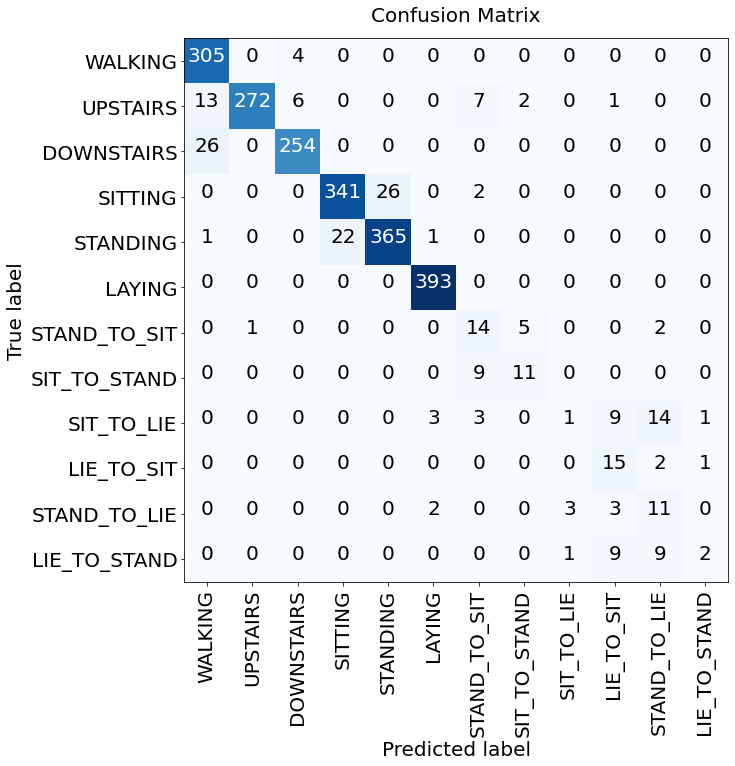

In [49]:
show_confusion_matrix(UCImodels['GRU_CNN'],UCIhalf_testFFT,UCItestY,title="Confusion Matrix",activity_list=UCILabels,save_add = None)

In [56]:
save_model_history(UCImodels['GRU_CNN'],'D:/Project/Datasets/UCI_HAPT_DATASET/UCIGRU_CNNhistory',UCIGRU_CNN,'D:/Project/Datasets/UCI_HAPT_DATASET/UCI_GRU_CNN')

INFO:tensorflow:Assets written to: D:/Project/Datasets/UCI_HAPT_DATASET/UCI_GRU_CNNLSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/UCI_HAPT_DATASET/UCI_GRU_CNNLSTM_CNN_SANDWICH\assets


#### CNN_GRU

In [52]:
UCICNN_GRU = UCImodels['CNN_GRU'].fit(UCIhalf_trainFFT, UCItrainY, epochs = 150, batch_size = 200, validation_data = (UCIhalf_valFFT, UCIvalY),callbacks=callbacks("UCIGRU_CNN", patience=30))

Epoch 1/150
44/44 [==============================] - 3s 60ms/step - loss: 0.0182 - accuracy: 0.9954 - f1_m: 0.9953 - precision_m: 0.9956 - recall_m: 0.9951 - val_loss: 0.8831 - val_accuracy: 0.8599 - val_f1_m: 0.8627 - val_precision_m: 0.8666 - val_recall_m: 0.8589
Epoch 2/150
44/44 [==============================] - 3s 59ms/step - loss: 0.0138 - accuracy: 0.9966 - f1_m: 0.9967 - precision_m: 0.9967 - recall_m: 0.9967 - val_loss: 1.3708 - val_accuracy: 0.7913 - val_f1_m: 0.7916 - val_precision_m: 0.7998 - val_recall_m: 0.7837
Epoch 3/150
44/44 [==============================] - 3s 58ms/step - loss: 0.0161 - accuracy: 0.9943 - f1_m: 0.9944 - precision_m: 0.9945 - recall_m: 0.9942 - val_loss: 0.9416 - val_accuracy: 0.8451 - val_f1_m: 0.8500 - val_precision_m: 0.8525 - val_recall_m: 0.8475
Epoch 4/150
44/44 [==============================] - 3s 58ms/step - loss: 0.0096 - accuracy: 0.9966 - f1_m: 0.9966 - precision_m: 0.9968 - recall_m: 0.9965 - val_loss: 0.9949 - val_accuracy: 0.8223 - va

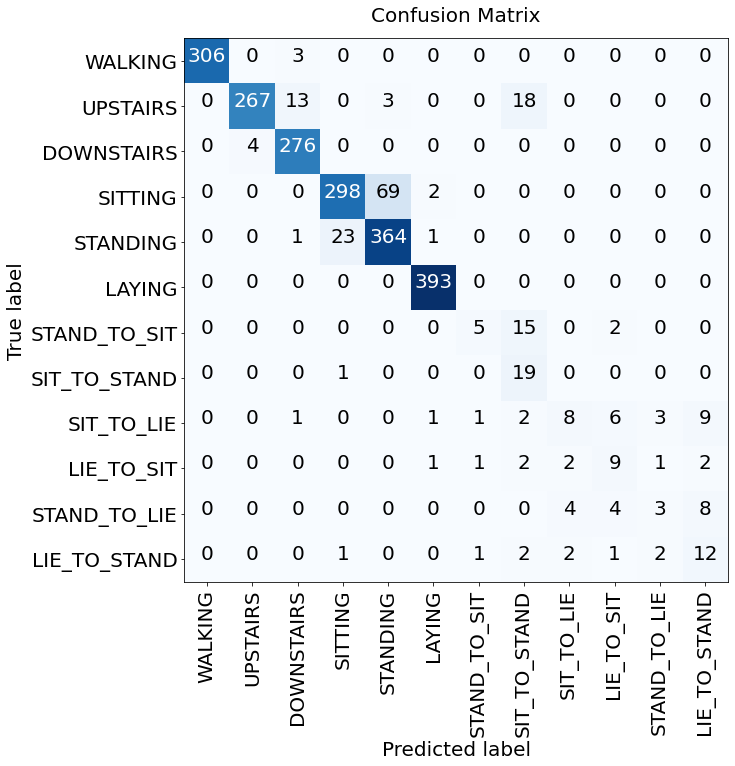

In [53]:
show_confusion_matrix(UCImodels['CNN_GRU'],UCIhalf_testFFT,UCItestY,title="Confusion Matrix",activity_list=UCILabels,save_add = None)

In [57]:
save_model_history(UCImodels['CNN_GRU'],'D:/Project/Datasets/UCI_HAPT_DATASET/UCICNN_GRUhistory',UCICNN_GRU,'D:/Project/Datasets/UCI_HAPT_DATASET/UCI_CNN_GRU')

INFO:tensorflow:Assets written to: D:/Project/Datasets/UCI_HAPT_DATASET/UCI_CNN_GRULSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/UCI_HAPT_DATASET/UCI_CNN_GRULSTM_CNN_SANDWICH\assets


### WISDM training model
#### LSTM_CNN_SANDWICH

In [25]:
#WISDMhalf_trainFFT,WISDMtrainY,WISDMhalf_testFFT,WISDMtestY,WISDMhalf_valFFT,WISDMvalY
WISDMLSTM_CNN_SANDWICH = WISDMmodels['LSTM_CNN_SANDWICH'].fit(WISDMhalf_trainFFT, WISDMtrainY, epochs = 100, batch_size = 200, validation_data = (WISDMhalf_valFFT, WISDMvalY),callbacks=callbacks("WISDMLSTM_CNN_SANDWICH", patience=30))

Epoch 1/100
174/174 [==============================] - 51s 237ms/step - loss: 1.5013 - accuracy: 0.3498 - f1_m: 0.0752 - precision_m: 0.3758 - recall_m: 0.0424 - val_loss: 1.7187 - val_accuracy: 0.3814 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00663 
Epoch 2/100
174/174 [==============================] - 39s 221ms/step - loss: 1.2406 - accuracy: 0.5020 - f1_m: 0.2283 - precision_m: 0.6310 - recall_m: 0.1406 - val_loss: 1.6339 - val_accuracy: 0.1377 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00s - loss: 1.2682 - accuracy: 0.4869 - f1_m: 0.1980 - precision_m: 0.6027 - recall_m - ETA: 9s - loss: 1.2646 - accuracy - ETA: 3s - loss: 1.2488 - accuracy: 0.4983 - f1_m: 0.2196 - prec
Epoch 3/100
174/174 [==============================] - 38s 221ms/step - loss: 1.0725 - accuracy: 0.5821 - f1_m: 0.4101 - precision_m: 0.7451 - recall_m: 0.2848 - val_loss: 1.3185 - val_accuracy: 0.4152 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0

174/174 [==============================] - 44s 251ms/step - loss: 0.3607 - accuracy: 0.8499 - f1_m: 0.8425 - precision_m: 0.8971 - recall_m: 0.7943 - val_loss: 0.6302 - val_accuracy: 0.7717 - val_f1_m: 0.7682 - val_precision_m: 0.8215 - val_recall_m: 0.7258
Epoch 31/100
174/174 [==============================] - 43s 247ms/step - loss: 0.3571 - accuracy: 0.8483 - f1_m: 0.8412 - precision_m: 0.8940 - recall_m: 0.7946 - val_loss: 0.7879 - val_accuracy: 0.7439 - val_f1_m: 0.7429 - val_precision_m: 0.7843 - val_recall_m: 0.7089
Epoch 32/100
174/174 [==============================] - 237s 1s/step - loss: 0.3518 - accuracy: 0.8507 - f1_m: 0.8442 - precision_m: 0.8967 - recall_m: 0.7977 - val_loss: 0.8027 - val_accuracy: 0.7328 - val_f1_m: 0.7292 - val_precision_m: 0.7699 - val_recall_m: 0.6959
Epoch 33/100
174/174 [==============================] - 38s 217ms/step - loss: 0.3520 - accuracy: 0.8513 - f1_m: 0.8435 - precision_m: 0.8965 - recall_m: 0.7967 - val_loss: 0.8494 - val_accuracy: 0.7241

174/174 [==============================] - 43s 248ms/step - loss: 0.2975 - accuracy: 0.8823 - f1_m: 0.8773 - precision_m: 0.9082 - recall_m: 0.8486 - val_loss: 0.8965 - val_accuracy: 0.7472 - val_f1_m: 0.7524 - val_precision_m: 0.7725 - val_recall_m: 0.7344


In [27]:
WISDMLSTM_CNN = WISDMmodels['LSTM_CNN'].fit(WISDMhalf_trainFFT, WISDMtrainY, epochs = 100, batch_size = 400, validation_data = (WISDMhalf_valFFT, WISDMvalY),callbacks=callbacks("WISDMLSTM_CNN", patience=30))

Epoch 1/100
87/87 [==============================] - 16s 180ms/step - loss: 0.9447 - accuracy: 0.5814 - f1_m: 0.4462 - precision_m: 0.7433 - recall_m: 0.3403 - val_loss: 0.8163 - val_accuracy: 0.7247 - val_f1_m: 0.5378 - val_precision_m: 0.7740 - val_recall_m: 0.4482
Epoch 2/100
87/87 [==============================] - 12s 135ms/step - loss: 0.8007 - accuracy: 0.7066 - f1_m: 0.6691 - precision_m: 0.8453 - recall_m: 0.5664 - val_loss: 0.9421 - val_accuracy: 0.6721 - val_f1_m: 0.4682 - val_precision_m: 0.6970 - val_recall_m: 0.4064
Epoch 3/100
87/87 [==============================] - 12s 142ms/step - loss: 0.7080 - accuracy: 0.7375 - f1_m: 0.7034 - precision_m: 0.8627 - recall_m: 0.6067 - val_loss: 0.9311 - val_accuracy: 0.6496 - val_f1_m: 0.4650 - val_precision_m: 0.7416 - val_recall_m: 0.3889
Epoch 4/100
87/87 [==============================] - 13s 147ms/step - loss: 0.6440 - accuracy: 0.7581 - f1_m: 0.7346 - precision_m: 0.8713 - recall_m: 0.6418 - val_loss: 0.7300 - val_accuracy: 0.7

87/87 [==============================] - 14s 156ms/step - loss: 0.2306 - accuracy: 0.9132 - f1_m: 0.9133 - precision_m: 0.9241 - recall_m: 0.9029 - val_loss: 0.8840 - val_accuracy: 0.8091 - val_f1_m: 0.8047 - val_precision_m: 0.8199 - val_recall_m: 0.7904
Epoch 32/100
87/87 [==============================] - 14s 161ms/step - loss: 0.2303 - accuracy: 0.9120 - f1_m: 0.9122 - precision_m: 0.9213 - recall_m: 0.9033 - val_loss: 0.8556 - val_accuracy: 0.8010 - val_f1_m: 0.7954 - val_precision_m: 0.8135 - val_recall_m: 0.7785
Epoch 33/100
87/87 [==============================] - 14s 159ms/step - loss: 0.2218 - accuracy: 0.9175 - f1_m: 0.9172 - precision_m: 0.9267 - recall_m: 0.9079 - val_loss: 1.1703 - val_accuracy: 0.7429 - val_f1_m: 0.7446 - val_precision_m: 0.7593 - val_recall_m: 0.7307
Epoch 34/100
87/87 [==============================] - 14s 162ms/step - loss: 0.2204 - accuracy: 0.9167 - f1_m: 0.9175 - precision_m: 0.9264 - recall_m: 0.9087 - val_loss: 1.2088 - val_accuracy: 0.7706 - val

In [28]:
WISDMLSTM_CNN_PARALLEL = WISDMmodels['LSTM_CNN_PARALLEL'].fit(WISDMhalf_trainFFT, WISDMtrainY, epochs = 100, batch_size = 400, validation_data = (WISDMhalf_valFFT, WISDMvalY),callbacks=callbacks("WISDMLSTM_CNN_PARALLEL", patience=30))

Epoch 1/100
87/87 [==============================] - 15s 102ms/step - loss: 1.4332 - accuracy: 0.5037 - f1_m: 0.1415 - precision_m: 0.7811 - recall_m: 0.0807 - val_loss: 1.0527 - val_accuracy: 0.6689 - val_f1_m: 0.2981 - val_precision_m: 0.7002 - val_recall_m: 0.2220
Epoch 2/100
87/87 [==============================] - 7s 77ms/step - loss: 0.9657 - accuracy: 0.7063 - f1_m: 0.4820 - precision_m: 0.8602 - recall_m: 0.3466 - val_loss: 0.8570 - val_accuracy: 0.6903 - val_f1_m: 0.5858 - val_precision_m: 0.7559 - val_recall_m: 0.4952
Epoch 3/100
87/87 [==============================] - 7s 80ms/step - loss: 0.7633 - accuracy: 0.7419 - f1_m: 0.7162 - precision_m: 0.8468 - recall_m: 0.6215 - val_loss: 0.7900 - val_accuracy: 0.6961 - val_f1_m: 0.6412 - val_precision_m: 0.7525 - val_recall_m: 0.5748
Epoch 4/100
87/87 [==============================] - 7s 82ms/step - loss: 0.6693 - accuracy: 0.7647 - f1_m: 0.7522 - precision_m: 0.8539 - recall_m: 0.6724 - val_loss: 0.7423 - val_accuracy: 0.7146 - 

Epoch 32/100
87/87 [==============================] - 8s 94ms/step - loss: 0.2849 - accuracy: 0.8997 - f1_m: 0.8996 - precision_m: 0.9176 - recall_m: 0.8822 - val_loss: 0.8037 - val_accuracy: 0.7398 - val_f1_m: 0.7366 - val_precision_m: 0.7778 - val_recall_m: 0.7025
Epoch 33/100
87/87 [==============================] - 8s 94ms/step - loss: 0.2818 - accuracy: 0.9009 - f1_m: 0.9016 - precision_m: 0.9186 - recall_m: 0.8851 - val_loss: 0.6850 - val_accuracy: 0.7809 - val_f1_m: 0.7794 - val_precision_m: 0.8115 - val_recall_m: 0.7514
Epoch 34/100
87/87 [==============================] - 8s 94ms/step - loss: 0.2810 - accuracy: 0.9024 - f1_m: 0.9023 - precision_m: 0.9210 - recall_m: 0.8845 - val_loss: 0.6688 - val_accuracy: 0.7806 - val_f1_m: 0.7785 - val_precision_m: 0.8117 - val_recall_m: 0.7497
Epoch 35/100
87/87 [==============================] - 8s 94ms/step - loss: 0.2767 - accuracy: 0.9029 - f1_m: 0.9033 - precision_m: 0.9199 - recall_m: 0.8874 - val_loss: 0.6753 - val_accuracy: 0.7798 

In [30]:
WISDMCNN_GRU = WISDMmodels['CNN_GRU'].fit(WISDMhalf_trainFFT, WISDMtrainY, epochs = 100, batch_size = 400, validation_data = (WISDMhalf_valFFT, WISDMvalY),callbacks=callbacks("WISDMCNN_GRU", patience=30))

Epoch 1/100
87/87 [==============================] - 4s 42ms/step - loss: 0.0579 - accuracy: 0.9781 - f1_m: 0.9781 - precision_m: 0.9787 - recall_m: 0.9775 - val_loss: 1.3581 - val_accuracy: 0.7448 - val_f1_m: 0.7440 - val_precision_m: 0.7488 - val_recall_m: 0.7393
Epoch 2/100
87/87 [==============================] - 4s 41ms/step - loss: 0.0543 - accuracy: 0.9799 - f1_m: 0.9800 - precision_m: 0.9805 - recall_m: 0.9794 - val_loss: 1.8093 - val_accuracy: 0.6842 - val_f1_m: 0.6864 - val_precision_m: 0.6890 - val_recall_m: 0.6838
Epoch 3/100
87/87 [==============================] - 4s 41ms/step - loss: 0.0533 - accuracy: 0.9802 - f1_m: 0.9803 - precision_m: 0.9810 - recall_m: 0.9796 - val_loss: 1.5787 - val_accuracy: 0.7259 - val_f1_m: 0.7264 - val_precision_m: 0.7313 - val_recall_m: 0.7217
Epoch 4/100
87/87 [==============================] - 4s 41ms/step - loss: 0.0504 - accuracy: 0.9811 - f1_m: 0.9812 - precision_m: 0.9818 - recall_m: 0.9806 - val_loss: 1.0973 - val_accuracy: 0.7983 - va

Epoch 32/100
87/87 [==============================] - 4s 50ms/step - loss: 0.0212 - accuracy: 0.9928 - f1_m: 0.9928 - precision_m: 0.9929 - recall_m: 0.9927 - val_loss: 1.6253 - val_accuracy: 0.7761 - val_f1_m: 0.7754 - val_precision_m: 0.7773 - val_recall_m: 0.7736
Epoch 33/100
87/87 [==============================] - 4s 50ms/step - loss: 0.0174 - accuracy: 0.9942 - f1_m: 0.9942 - precision_m: 0.9943 - recall_m: 0.9940 - val_loss: 1.4145 - val_accuracy: 0.7917 - val_f1_m: 0.7913 - val_precision_m: 0.7927 - val_recall_m: 0.7899
Epoch 34/100
87/87 [==============================] - 4s 49ms/step - loss: 0.0183 - accuracy: 0.9934 - f1_m: 0.9933 - precision_m: 0.9934 - recall_m: 0.9932 - val_loss: 2.1481 - val_accuracy: 0.7132 - val_f1_m: 0.7154 - val_precision_m: 0.7171 - val_recall_m: 0.7138
Epoch 35/100
87/87 [==============================] - 4s 49ms/step - loss: 0.0163 - accuracy: 0.9942 - f1_m: 0.9943 - precision_m: 0.9944 - recall_m: 0.9942 - val_loss: 1.3449 - val_accuracy: 0.8099 

In [31]:
WISDMGRU_CNN = WISDMmodels['GRU_CNN'].fit(WISDMhalf_trainFFT, WISDMtrainY, epochs = 100, batch_size = 400, validation_data = (WISDMhalf_valFFT, WISDMvalY),callbacks=callbacks("WISDMGRU_CNN", patience=30))

Epoch 1/100
87/87 [==============================] - 12s 84ms/step - loss: 0.6944 - accuracy: 0.7090 - f1_m: 0.6704 - precision_m: 0.7915 - recall_m: 0.5910 - val_loss: 1.3568 - val_accuracy: 0.4768 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
87/87 [==============================] - 5s 60ms/step - loss: 0.4038 - accuracy: 0.8348 - f1_m: 0.8308 - precision_m: 0.8764 - recall_m: 0.7901 - val_loss: 1.1372 - val_accuracy: 0.6737 - val_f1_m: 0.1363 - val_precision_m: 0.6400 - val_recall_m: 0.0995f1_m: 0.8278 - precision_m: 0
Epoch 3/100
87/87 [==============================] - 5s 63ms/step - loss: 0.3447 - accuracy: 0.8612 - f1_m: 0.8588 - precision_m: 0.8881 - recall_m: 0.8315 - val_loss: 1.2021 - val_accuracy: 0.5386 - val_f1_m: 0.3162 - val_precision_m: 0.6727 - val_recall_m: 0.2334
Epoch 4/100
87/87 [==============================] - 6s 66ms/step - loss: 0.3095 - accuracy: 0.8737 - f1_m: 0.8730 - precision_m: 0.8952 - recall_m: 0.8520 - va

87/87 [==============================] - 6s 71ms/step - loss: 0.1276 - accuracy: 0.9498 - f1_m: 0.9496 - precision_m: 0.9531 - recall_m: 0.9460 - val_loss: 1.1683 - val_accuracy: 0.7976 - val_f1_m: 0.7998 - val_precision_m: 0.8089 - val_recall_m: 0.7911
Epoch 32/100
87/87 [==============================] - 6s 71ms/step - loss: 0.1266 - accuracy: 0.9496 - f1_m: 0.9498 - precision_m: 0.9531 - recall_m: 0.9465 - val_loss: 1.0810 - val_accuracy: 0.7538 - val_f1_m: 0.7573 - val_precision_m: 0.7629 - val_recall_m: 0.7519
Epoch 33/100
87/87 [==============================] - 6s 71ms/step - loss: 0.1231 - accuracy: 0.9520 - f1_m: 0.9522 - precision_m: 0.9553 - recall_m: 0.9492 - val_loss: 1.0123 - val_accuracy: 0.8030 - val_f1_m: 0.8051 - val_precision_m: 0.8124 - val_recall_m: 0.7981
Epoch 34/100
87/87 [==============================] - 6s 71ms/step - loss: 0.1208 - accuracy: 0.9517 - f1_m: 0.9516 - precision_m: 0.9547 - recall_m: 0.9485 - val_loss: 1.4676 - val_accuracy: 0.7366 - val_f1_m: 0

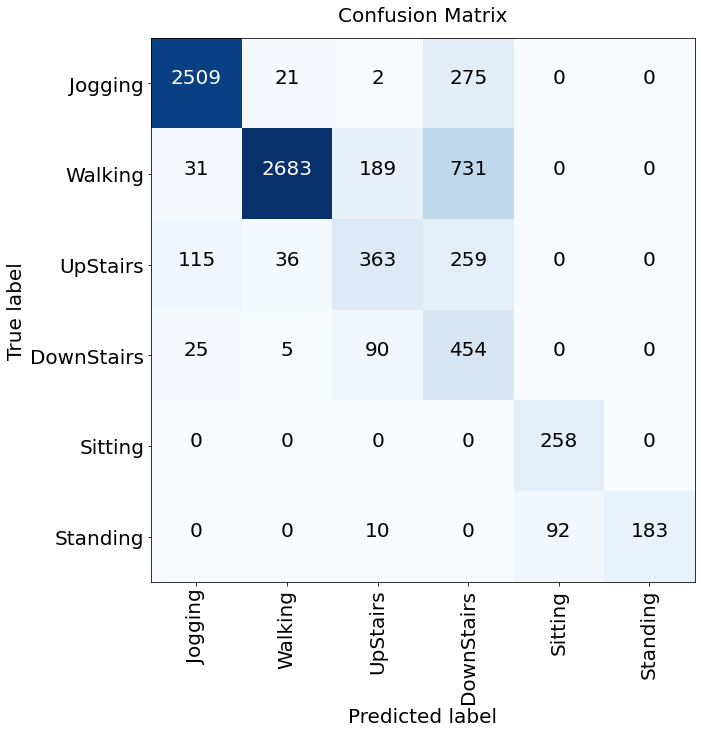

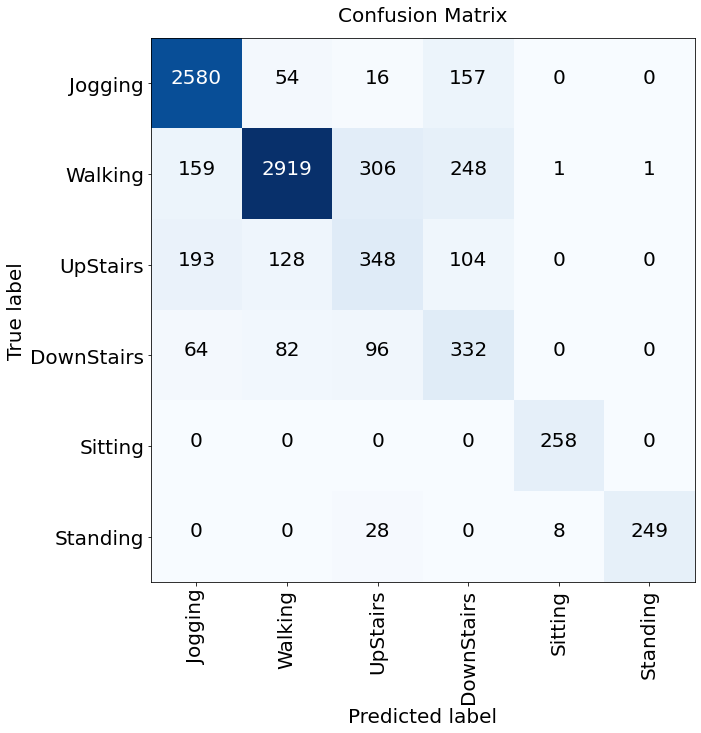

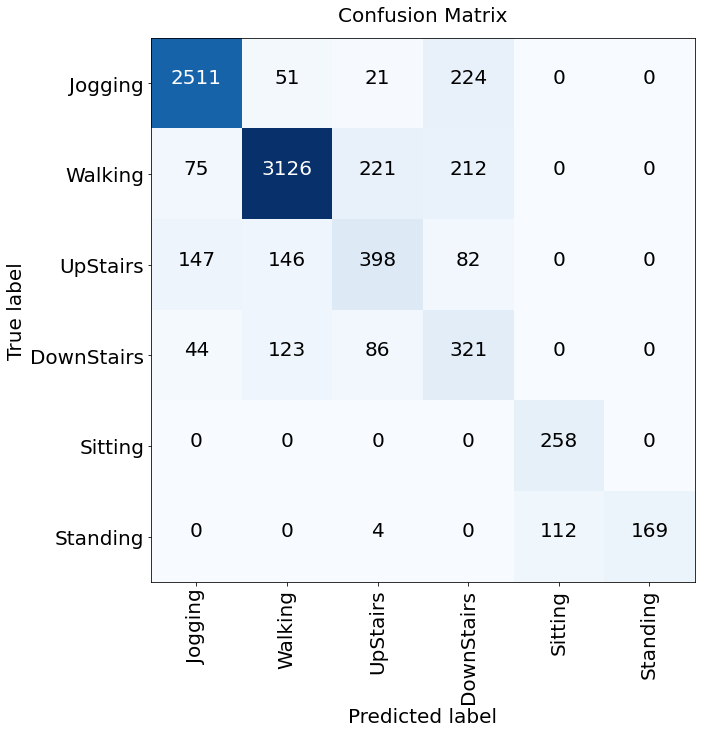

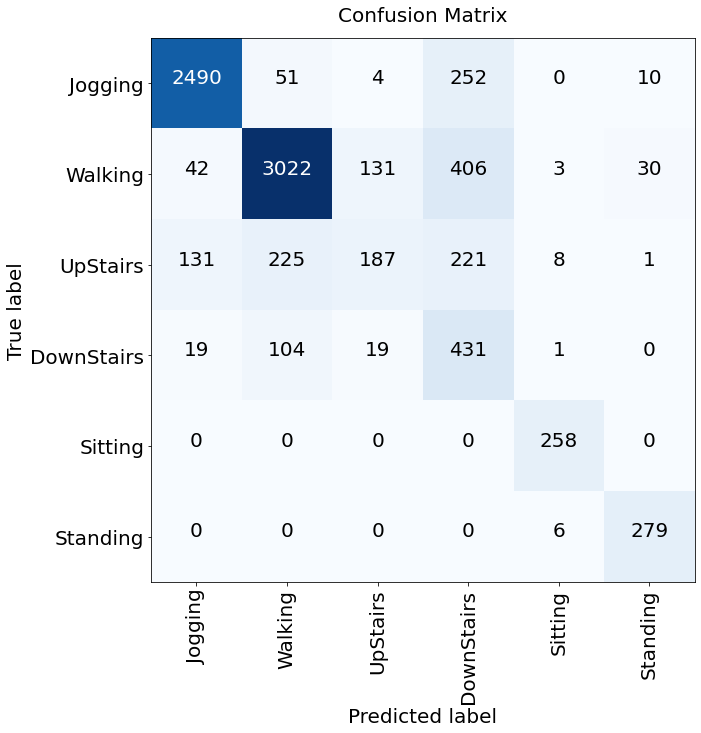

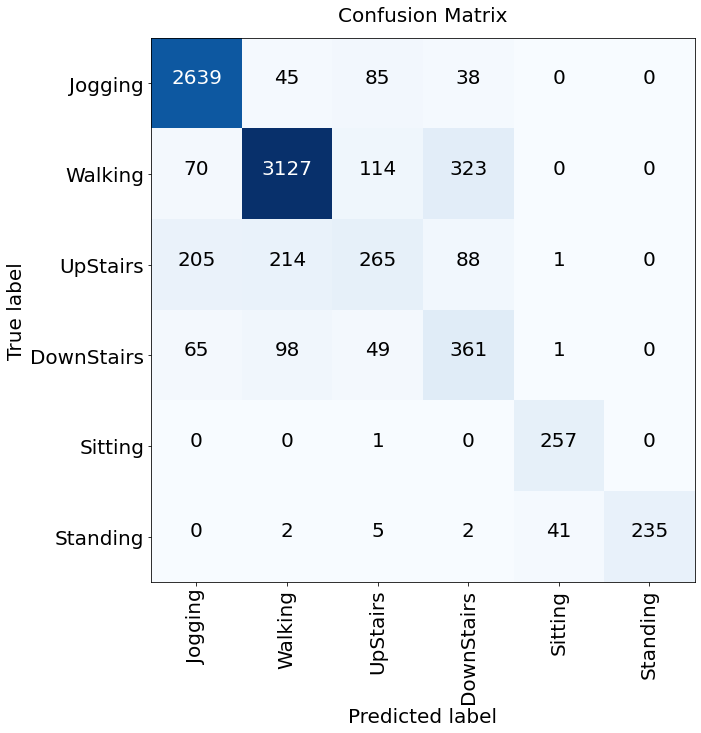

In [32]:
show_confusion_matrix(WISDMmodels['LSTM_CNN_SANDWICH'],WISDMhalf_testFFT,WISDMtestY,title="Confusion Matrix",activity_list=WISDMLabels,save_add = None)
show_confusion_matrix(WISDMmodels['LSTM_CNN'],WISDMhalf_testFFT,WISDMtestY,title="Confusion Matrix",activity_list=WISDMLabels,save_add = None)
show_confusion_matrix(WISDMmodels['LSTM_CNN_PARALLEL'],WISDMhalf_testFFT,WISDMtestY,title="Confusion Matrix",activity_list=WISDMLabels,save_add = None)
show_confusion_matrix(WISDMmodels['GRU_CNN'],WISDMhalf_testFFT,WISDMtestY,title="Confusion Matrix",activity_list=WISDMLabels,save_add = None)
show_confusion_matrix(WISDMmodels['CNN_GRU'],WISDMhalf_testFFT,WISDMtestY,title="Confusion Matrix",activity_list=WISDMLabels,save_add = None)

In [33]:
save_model_history(WISDMmodels['LSTM_CNN_SANDWICH'],'D:/Project/Datasets/WISDM_Dataset/WISDMLSTM_CNN_SANDWICHhistory',WISDMLSTM_CNN_SANDWICH,'D:/Project/Datasets/WISDM_Dataset/WISDM_CNN_GRU')
save_model_history(WISDMmodels['LSTM_CNN'],'D:/Project/Datasets/WISDM_Dataset/WISDMLSTM_CNNhistory',WISDMLSTM_CNN,'D:/Project/Datasets/WISDM_Dataset/WISDM_LSTM_CNN')
save_model_history(WISDMmodels['LSTM_CNN_PARALLEL'],'D:/Project/Datasets/WISDM_Dataset/WISDMLSTM_CNN_PARALLELhistory',WISDMLSTM_CNN_PARALLEL,'D:/Project/Datasets/WISDM_Dataset/WISDM_LSTM_CNN_PARALLEL')
save_model_history(WISDMmodels['GRU_CNN'],'D:/Project/Datasets/WISDM_Dataset/WISDMGRU_CNNhistory',WISDMGRU_CNN,'D:/Project/Datasets/WISDM_Dataset/WISDM_GRU_CNN')
save_model_history(WISDMmodels['LSTM_CNN_SANDWICH'],'D:/Project/Datasets/WISDM_Dataset/WISDMLSTM_CNN_SANDWICHhistory',WISDMCNN_GRU,'D:/Project/Datasets/WISDM_Dataset/WISDM_CNN_GRU')

INFO:tensorflow:Assets written to: D:/Project/Datasets/WISDM_Dataset/WISDM_CNN_GRULSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/WISDM_Dataset/WISDM_CNN_GRULSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/WISDM_Dataset/WISDM_LSTM_CNNLSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/WISDM_Dataset/WISDM_LSTM_CNNLSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/WISDM_Dataset/WISDM_LSTM_CNN_PARALLELLSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/WISDM_Dataset/WISDM_LSTM_CNN_PARALLELLSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/WISDM_Dataset/WISDM_GRU_CNNLSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/WISDM_Dataset/WISDM_GRU_CNNLSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/WISDM_Dataset/WISDM_CNN_GRULSTM_CNN_SANDWICH\assets


INFO:tensorflow:Assets written to: D:/Project/Datasets/WISDM_Dataset/WISDM_CNN_GRULSTM_CNN_SANDWICH\assets
